# EECS16A: Homework 11

# Satellite Cloud Monitoring (Q5)

## (a) Plot first, 50th, 75th columns

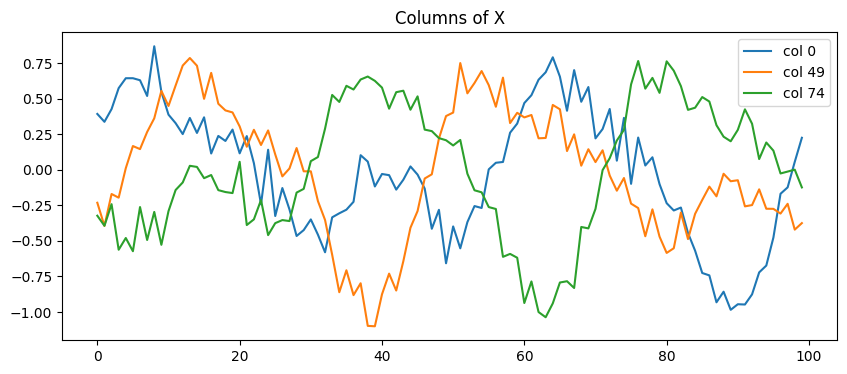

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Load the signal matrix
X = np.load('signal_matrix.npy')
N, T = X.shape
plt.figure(figsize=(10,4))
for idx in [0,49,74]:
    plt.plot(X[:,idx], label=f'col {idx}')
plt.legend()
plt.title("Columns of X")
plt.show()

## (b) PCA first 3 PCs + singular values

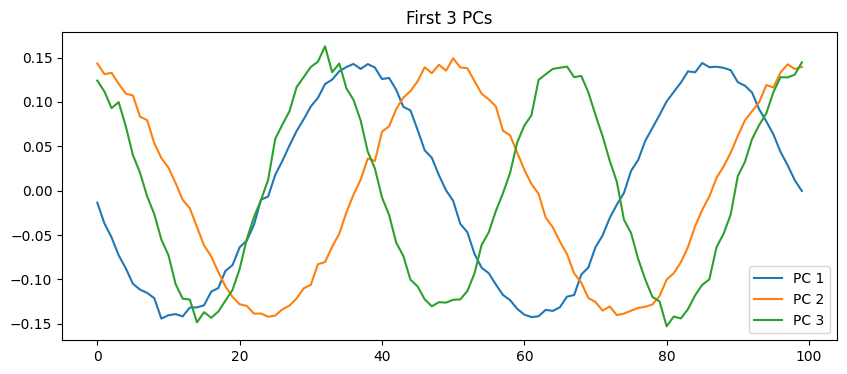

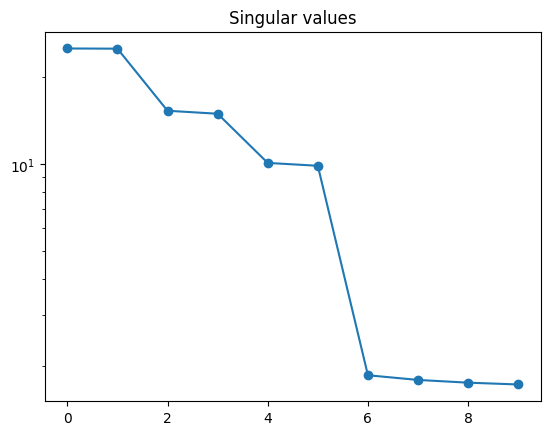

In [2]:
X_centered = X - np.mean(X, axis=0)
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
n_components = 10
pcs = U[:, :n_components]  # shape (N, 10)
sv = S[:n_components]

plt.figure(figsize=(10,4))
for i in range(3):
    plt.plot(pcs[:, i], label=f'PC {i+1}')
plt.legend()
plt.title("First 3 PCs")
plt.show()

plt.figure()
plt.semilogy(sv, 'o-')
plt.title("Singular values")
plt.show()

## (c) Circulant structure explanation
No code required.

## (d) Compare PCA vs DFT reconstruction

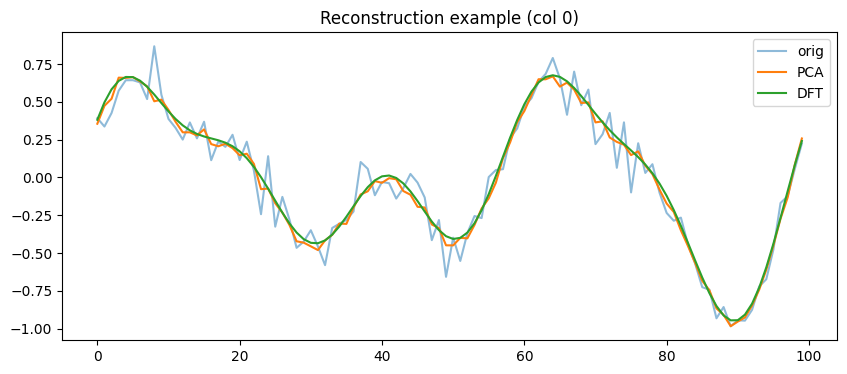

In [3]:
k = 5

X_mean = np.mean(X, axis=0)
X_centered_k = U[:, :k+1] @ np.diag(S[:k+1]) @ Vt[:k+1, :]
Xpca = X_centered_k + X_mean

x0 = X[:, 0]
n = np.arange(N)
freqs = np.arange(N)

dft_coeff = np.zeros(N, dtype=complex)
for ell in freqs:
    dft_coeff[ell] = np.sum(x0 * np.exp(-2j * np.pi * ell * n / N))

largest_indices = np.argsort(np.abs(dft_coeff))[-k-1:]
dft_coeff_trunc = np.zeros_like(dft_coeff)
dft_coeff_trunc[largest_indices] = dft_coeff[largest_indices]

x0_hat = np.zeros(N, dtype=complex)
for n_idx in n:
    x0_hat[n_idx] = (1 / N) * np.sum(dft_coeff_trunc * np.exp(2j * np.pi * freqs * n_idx / N))

x0_hat = x0_hat.real

plt.figure(figsize=(10,4))
plt.plot(X[:,0], label='orig', alpha=0.5)
plt.plot(Xpca[:,0], label='PCA')
plt.plot(x0_hat, label='DFT')
plt.legend()
plt.title("Reconstruction example (col 0)")
plt.show()

## (e) Compare DFT matrix with left singular matrix (U)

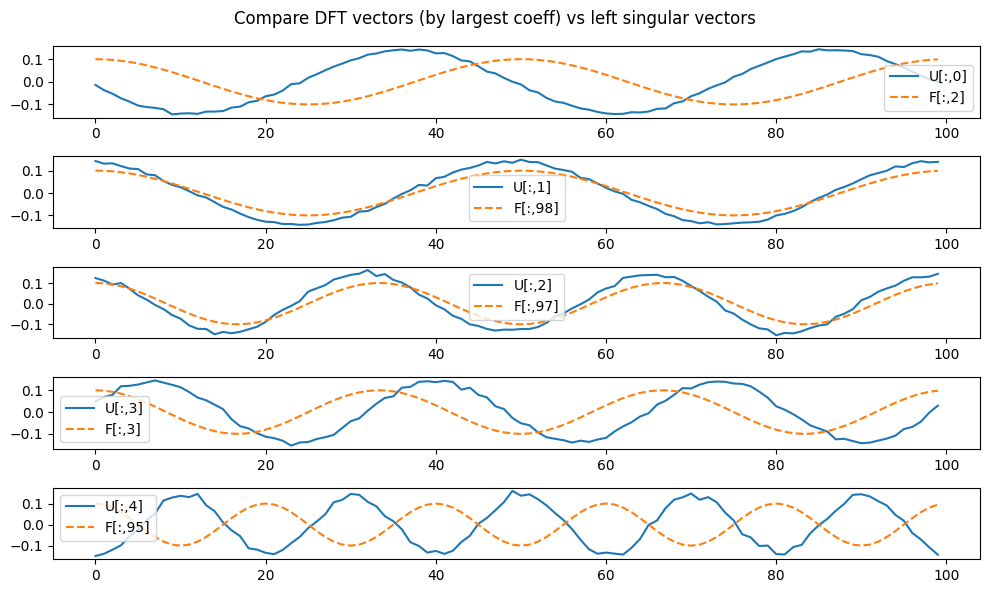

In [4]:
# Build DFT matrix explicitly
n = np.arange(N)
freqs = np.arange(N)
F = np.zeros((N, N), dtype=complex)
for ell in freqs:
    F[:, ell] = np.exp(2j * np.pi * ell * n / N) / np.sqrt(N)

# Compare DFT basis vectors corresponding to largest coefficients vs left singular vectors
plt.figure(figsize=(10,6))
for i in range(k):
    plt.subplot(k,1,i+1)
    plt.plot(U[:,i].real, label='U[:,{}]'.format(i))
    dft_idx = largest_indices[-(i+1)]
    plt.plot(F[:,dft_idx].real, '--', label='F[:,{}]'.format(dft_idx))
    plt.legend()
plt.suptitle("Compare DFT vectors (by largest coeff) vs left singular vectors")
plt.tight_layout()
plt.show()

## Problem 6: Segway Tours

Run the following block of code first to get all the dependencies.

In [6]:
# %load gauss_elim.py
from gauss_elim import gauss_elim

In [7]:
from numpy import zeros, cos, sin, arange, around, hstack
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle
import numpy as np
from scipy.interpolate import interp1d
import scipy as sp

## Dynamics

In [8]:
# Dynamics: state to state
A = np.array([[1, 0.05, -.01, 0],
              [0, 0.22, -.17, -.01],
              [0, 0.1, 1.14, 0.10],
              [0, 1.66, 2.85, 1.14]]);
# Control to state
b = np.array([.01, .21, -.03, -0.44])
nr_states = b.shape[0]

# Initial state
state0 = np.array([-0.3853493, 6.1032227, 0.8120005, -14])

# Final (terminal state)
stateFinal = np.array([0, 0, 0, 0])

## Part (d)

In [9]:
# Compute the powers of A

A2 = np.dot(A,A)

#Compute "Controllability Matrix" Q2 = [Ab b]

Q2 = np.zeros([4,2])
Q2[:,0] = np.dot(A,b)
Q2[:,1] = b

# Augmented Matrix for system of equations

Q2_aug = np.c_[Q2, stateFinal-np.dot(A2,state0)]

print('Augmented matrix for part f:\n')
print(Q2_aug)
gauss_elim(Q2_aug)

Augmented matrix for part f:

[[ 0.0208      0.01        0.02243475]
 [ 0.0557      0.21       -0.30785117]
 [-0.0572     -0.03        0.06193476]
 [-0.2385     -0.44        1.38671326]]


array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [-0., -0.,  1.],
       [ 0.,  0.,  0.]])

## Part (e)

In [10]:
# Compute the powers of A

A3 = np.dot(A2,A)

#Compute "Controllability Matrix" Q3=[A^2b Ab b]

Q3 = np.zeros([4,3])
Q3[:,0] = np.dot(A2,b)
Q3[:,1:] = Q2

# Augmented Matrix for system of equations

Q3_aug = np.c_[Q3, stateFinal-np.dot(A3,state0)]

print('Augmented matrix for part g:\n')
print(Q3_aug) 
gauss_elim(Q3_aug)

Augmented matrix for part g:

[[ 0.024157    0.0208      0.01        0.00642285]
 [ 0.024363    0.0557      0.21       -0.0921233 ]
 [-0.083488   -0.0572     -0.03        0.17849184]
 [-0.342448   -0.2385     -0.44        1.24633424]]


array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

## Part (f)

In [11]:
# Compute the powers of A

A4 = np.dot(A3,A)

#Compute "Controllability Matrix" Q4=[A^3b A^2b Ab b]

Q4 = np.zeros([4,4])
Q4[:,0] = np.dot(A3,b)
Q4[:,1:] = Q3

# Solution

np.linalg.solve(Q4, stateFinal-np.dot(A4,state0))

array([-13.24875075,  23.73325125, -11.57181872,   1.46515973])

## Part (g)

### Preamble
This function will take care of animating the segway

In [12]:
# frames per second in simulation
fps = 20
# length of the segway arm/stick
stick_length = 1.

def animate_segway(t, states, controls, length):
    #Animates the segway
    
    # Set up the figure, the axis, and the plot elements we want to animate
    fig = plt.figure()
    
    # some config
    segway_width = 0.4
    segway_height = 0.2
    
    # x coordinate of the segway stick
    segwayStick_x = length * np.add(states[:, 0],sin(states[:, 2]))
    segwayStick_y = length * cos(states[:, 2])
    
    # set the limits
    xmin = min(around(states[:, 0].min() - segway_width / 2.0, 1), around(segwayStick_x.min(), 1))
    xmax = max(around(states[:, 0].max() + segway_height / 2.0, 1), around(segwayStick_y.max(), 1))
    
    # create the axes
    ax = plt.axes(xlim=(xmin-.2, xmax+.2), ylim=(-length-.1, length+.1), aspect='equal')
    
    # display the current time
    time_text = ax.text(0.05, 0.9, 'time', transform=ax.transAxes)
    
    # display the current control
    control_text = ax.text(0.05, 0.8, 'control', transform=ax.transAxes)
    
    # create rectangle for the segway
    rect = Rectangle([states[0, 0] - segway_width / 2.0, -segway_height / 2],
        segway_width, segway_height, fill=True, color='gold', ec='blue')
    ax.add_patch(rect)
    
    # blank line for the stick with o for the ends
    stick_line, = ax.plot([], [], lw=2, marker='o', markersize=6, color='blue')

    # vector for the control (force)
    force_vec = ax.quiver([],[],[],[],angles='xy',scale_units='xy',scale=1)

    # initialization function: plot the background of each frame
    def init():
        time_text.set_text('')
        control_text.set_text('')
        rect.set_xy((0.0, 0.0))
        stick_line.set_data([], [])
        return time_text, rect, stick_line, control_text

    # animation function: update the objects
    def animate(i):
        time_text.set_text('time = {:2.2f}'.format(t[i]))
        control_text.set_text('force = {:2.3f}'.format(controls[i]))
        rect.set_xy((states[i, 0] - segway_width / 2.0, -segway_height / 2))
        stick_line.set_data([states[i, 0], segwayStick_x[i]], [0, segwayStick_y[i]])
        return time_text, rect, stick_line, control_text

    # call the animator function
    anim = animation.FuncAnimation(fig, animate, frames=len(t), init_func=init,
            interval=1000/fps, blit=False, repeat=False)
    return anim
    #plt.show()

### Plug in your controller here

In [13]:
controls = np.linalg.solve(Q4, stateFinal-np.dot(A4,state0))
print(controls)

[-13.24875075  23.73325125 -11.57181872   1.46515973]


### Simulation

In [14]:
# This will add an extra couple of seconds to the simulation after the input controls with no control
# the effect of this is just to show how the system will continue after the controller "stops controlling"
controls = np.append(controls,[0, 0])

# number of steps in the simulation
nr_steps = controls.shape[0]

# We now compute finer dynamics and control vectors for smoother visualization
Afine = sp.linalg.fractional_matrix_power(A,(1/fps))
Asum = np.eye(nr_states)
for i in range(1, fps):
    Asum = Asum + np.linalg.matrix_power(Afine,i)
    
bfine = np.linalg.inv(Asum).dot(b)

# We also expand the controls in the "intermediate steps" (only for visualization)
controls_final = np.outer(controls, np.ones(fps)).flatten()
controls_final = np.append(controls_final, [0])

# We compute all the states starting from x0 and using the controls
states = np.empty([fps*(nr_steps)+1, nr_states])
states[0,:] = state0;
for stepId in range(1,fps*(nr_steps)+1):
    states[stepId, :] = np.dot(Afine,states[stepId-1, :]) + controls_final[stepId-1] * bfine
    
# Now create the time vector for simulation
t = np.linspace(1/fps,nr_steps,fps*(nr_steps),endpoint=True)
t = np.append([0], t)

### Visualization

In [15]:
%matplotlib nbagg
# %matplotlib qt
anim = animate_segway(t, states, controls_final, stick_length)
anim

<IPython.core.display.Javascript object>